![kickstarter-logo](https://ksr-static.imgix.net/tq0sfld-kickstarter-logo-green.png?ixlib=rb-2.1.0&s=0cce952d7b55823ff451a58887a0c578)

# Workshop: Kickstarter data

Kickstarter is a crowdfunding website. Anyone can launch a fund to build something cool and anybody can chip in! It's an amazing resource for indie builders and when it first launched it was a really novel way to raise money around an idea.

We're going to go through the process of exploring and engineering data, building a model, and visualising the results. We'll try to predict wheher or not a kickstarter project will be funded.

**Links**
 - Kickstarter website: https://www.kickstarter.com/
 - Shared folder for class: https://drive.google.com/open?id=1PlcVyu8PmquwxkqAAZO0mSidS68xbNZW
 - This code: https://git.generalassemb.ly/DSga38/ds_ga_38

# 1. Load data

First of all we just load up the data and take a peek at what we have.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

`read_csv` takes a list of column names that should be interpretted as datetime objects. Pretty helpful if we know those in advance.

In [2]:
kaggle_data = pd.read_csv(
    './ks-projects-201801.csv',
    parse_dates=['deadline', 'launched'])

In [3]:
kaggle_data.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


We're going to build a model of whether a project will reach its goal. Our analysis would be pretty confused if we included unfinished projects (they are neither successful or failed).

In [4]:
kaggle_data['state'].value_counts(dropna=False)

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

So lets filter out the rows. We drop 6,361 rows

In [5]:
is_not_finished = kaggle_data['state'].isin(['live', 'undefined'])
kaggle_data_filtered = kaggle_data[~is_not_finished]


before = len(kaggle_data)
end = len(kaggle_data_filtered)
end - before

-6361

We'll also do a train test split nice and early! This helps us run a realistic test later on.

We're going for a 70/30 split. The random state is fixed so that the train-test rows are the same each time we run the code.

In [6]:
train, test = train_test_split(
    kaggle_data_filtered,
    train_size=0.7,
    test_size=0.3,
    random_state=1001,
)

Here's a little example of how to use string formatting to create nice log messages.

In [7]:
train_set_size = len(train)
print('Number of training rows = {:,d}'.format(train_set_size))

Number of training rows = 260,609


In [8]:
test_set_size = len(test)
print('Number of test rows = {:,d}'.format(test_set_size))

Number of test rows = 111,690


# 2. Exploratory Data Analysis (level 1)

Let's get into it!

What types do we have? Some numerical columns, some strings, some dates.

In [9]:
train.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

## 2.1 One-way feature analysis

### State

Distribution of the state. We'll try and predict this.

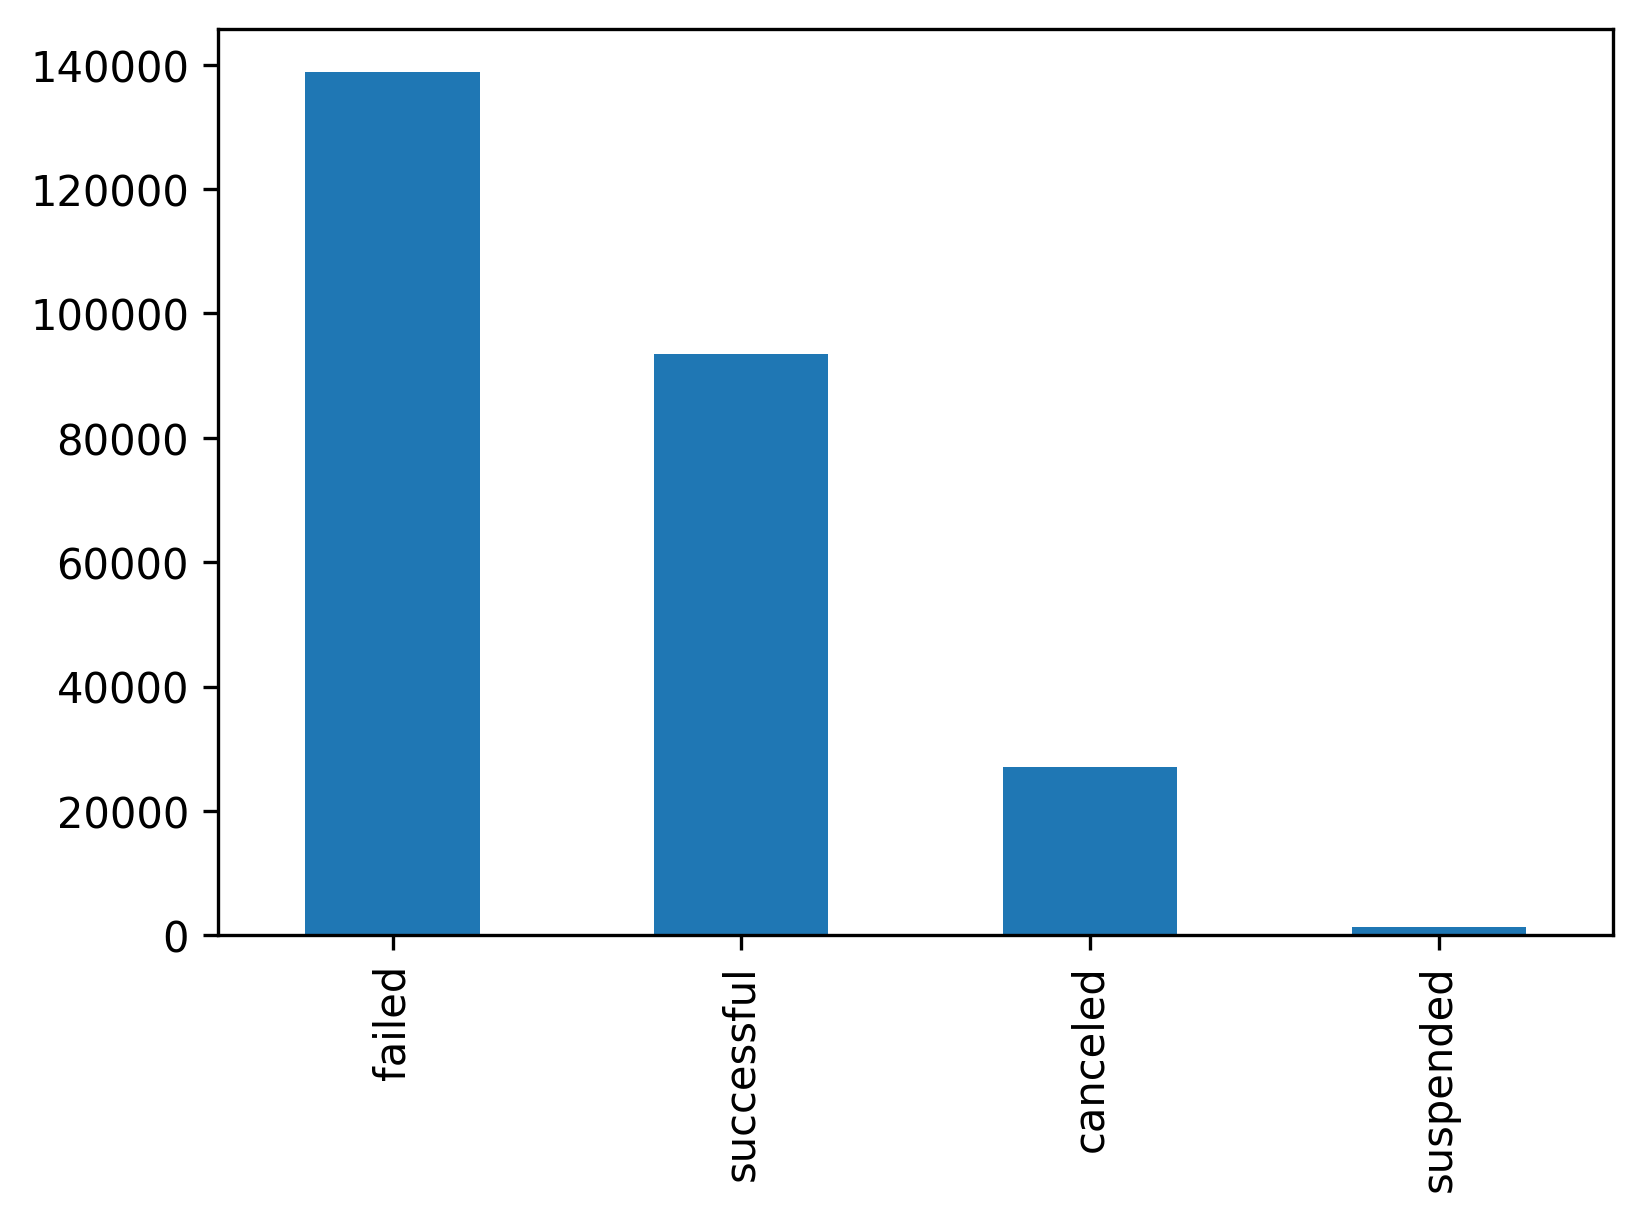

In [10]:
fg, ax = plt.subplots(dpi=300)
train['state'].value_counts().plot(kind='bar', ax=ax)

### Name

Are the project names unique?

In [11]:
train['name'].is_unique

False

No! Projects can have duplicate names. The most common names are quite funny:

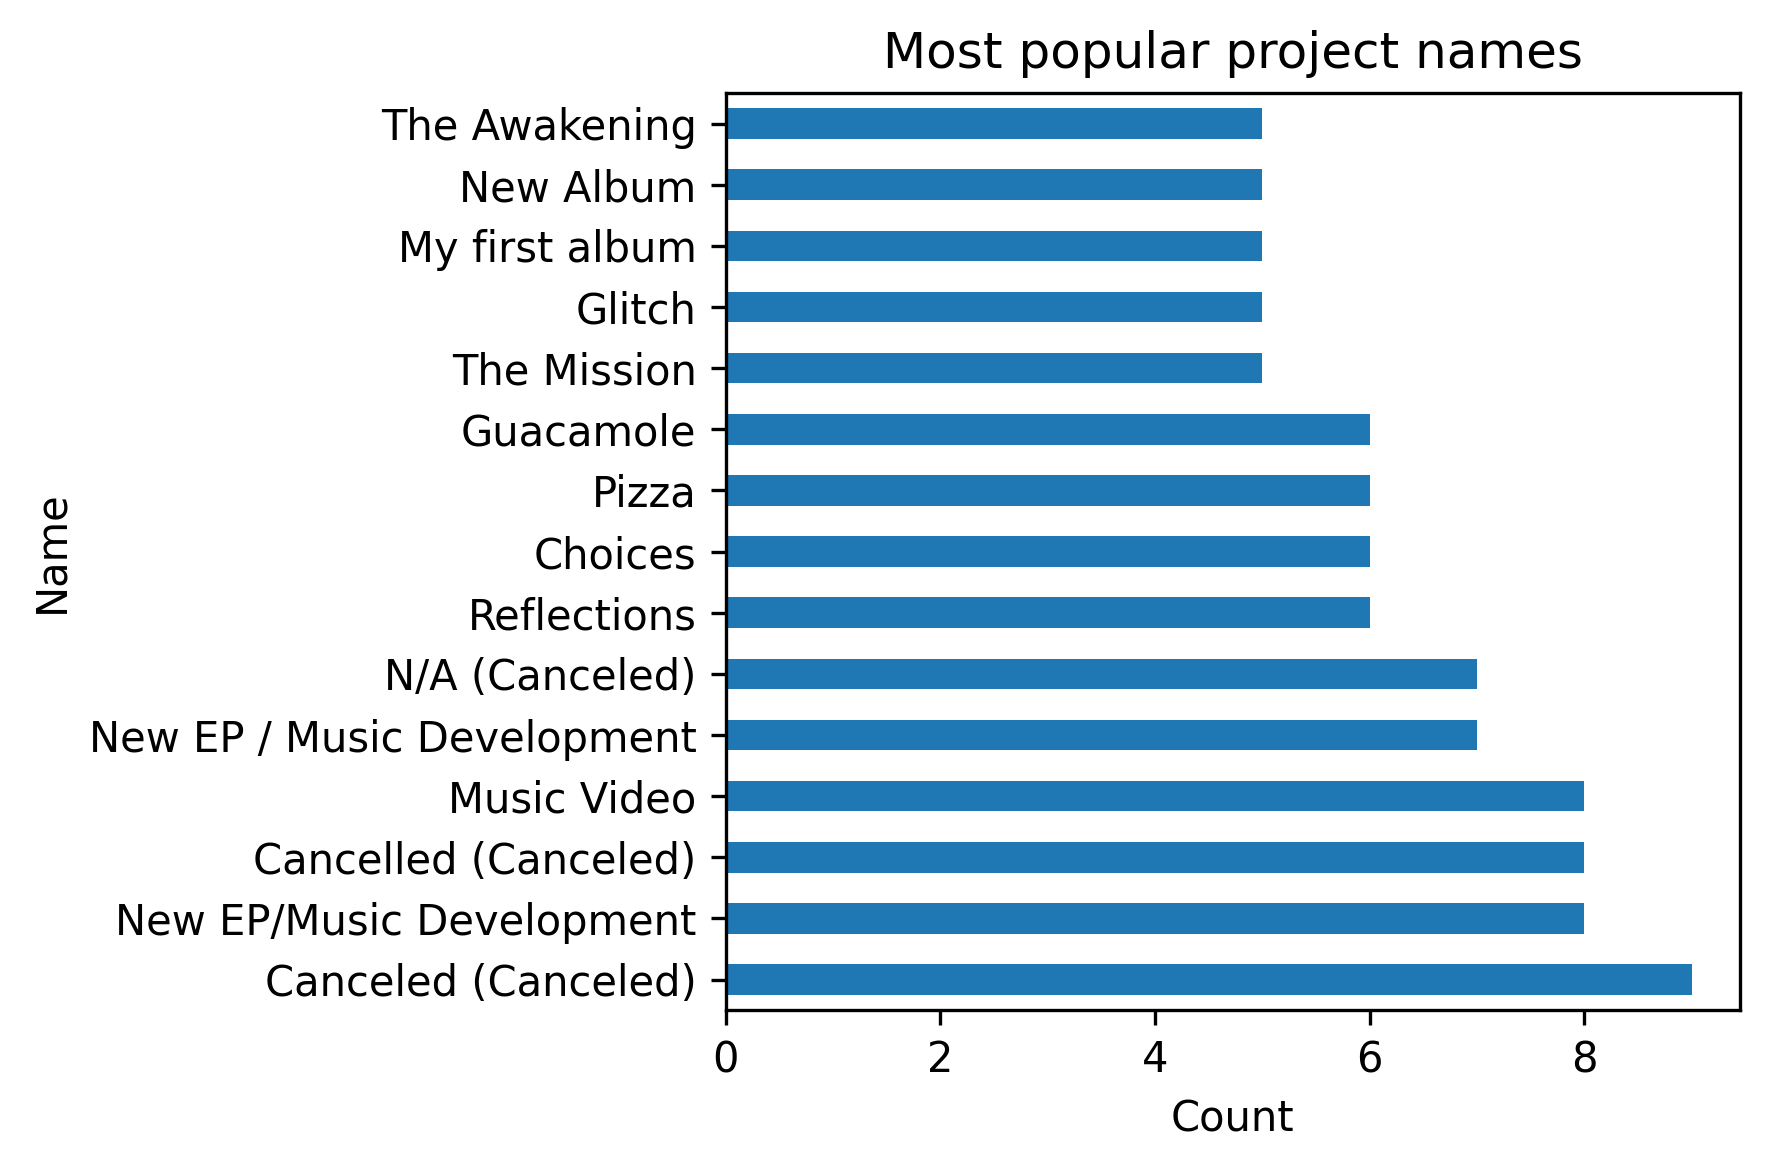

In [12]:
fg, ax = plt.subplots(dpi=300)
train['name'].value_counts().head(15).plot(kind='barh', ax=ax)
ax.set_title('Most popular project names')
ax.set_xlabel('Count')
ax.set_ylabel('Name')
fg.tight_layout()

## Goal

The goal is the total amount of money the project tried to raise. Here we show the distribution of the goal in logspace. Remember that positive only numbers, like prices, tend to be closer to log-normal distributed. This means that if we log the variable, it'll look normally distrbuted. 

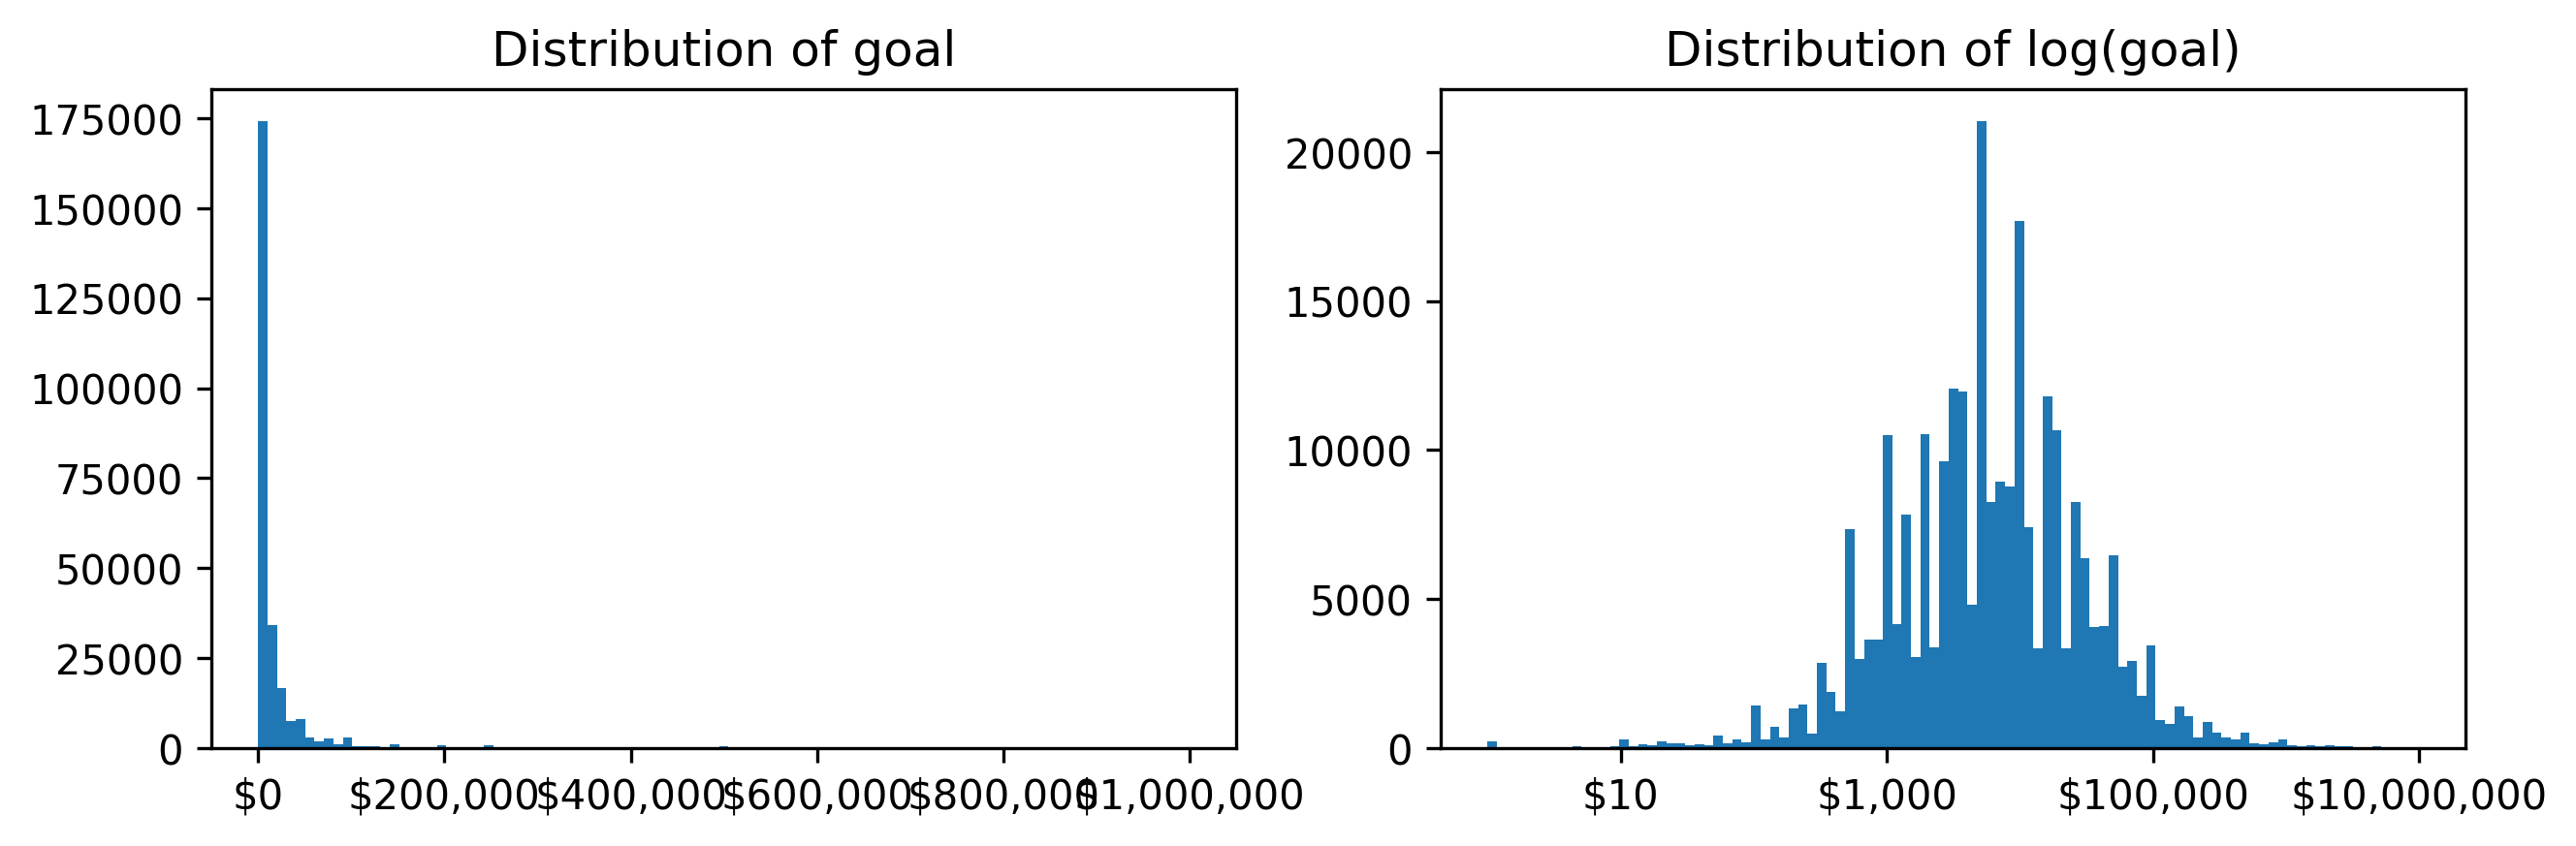

In [13]:
fg, axs = plt.subplots(dpi=300, ncols=2, figsize=(10, 3))

# Normal hist
bins = np.linspace(0, 10e5, 100)
train['usd_goal_real'].hist(bins=bins, grid=False, ax=axs[0])
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axs[0].set_title('Distribution of goal')

# Logged hist
bins = np.logspace(0, 7, 100)
axs[1].set_xscale('log')
axs[1].set_title('Distribution of log(goal)')
train['usd_goal_real'].hist(bins=bins, grid=False, ax=axs[1])
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

## 2.2 Feature-outcome analysis

Looks like successful projects tended to have lower goal amounts.

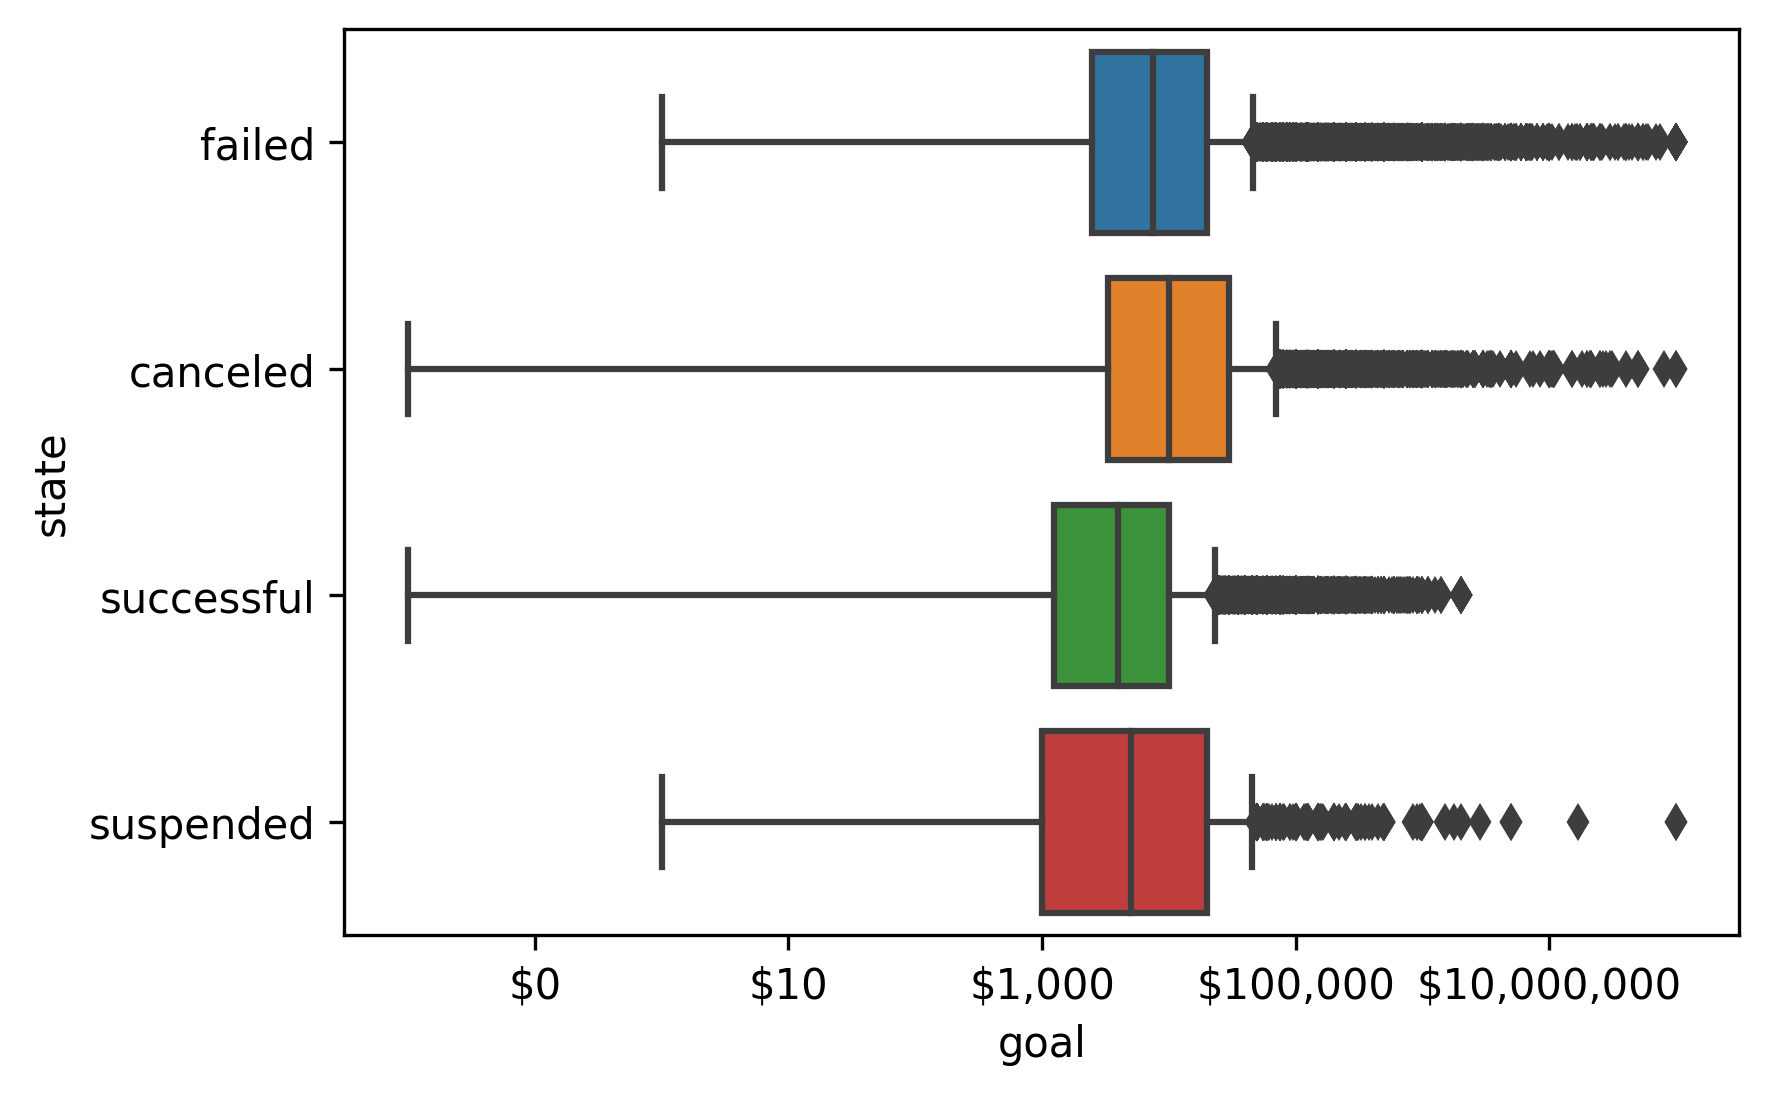

In [14]:
fg, ax = plt.subplots(dpi=300)
ax.set_xscale('log')

sns.boxplot(data=train, x='goal', y='state')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

## 2.3 Two-way feature analysis

We can go further and look at how those states look across different groups. That's a lot of data to analyse!

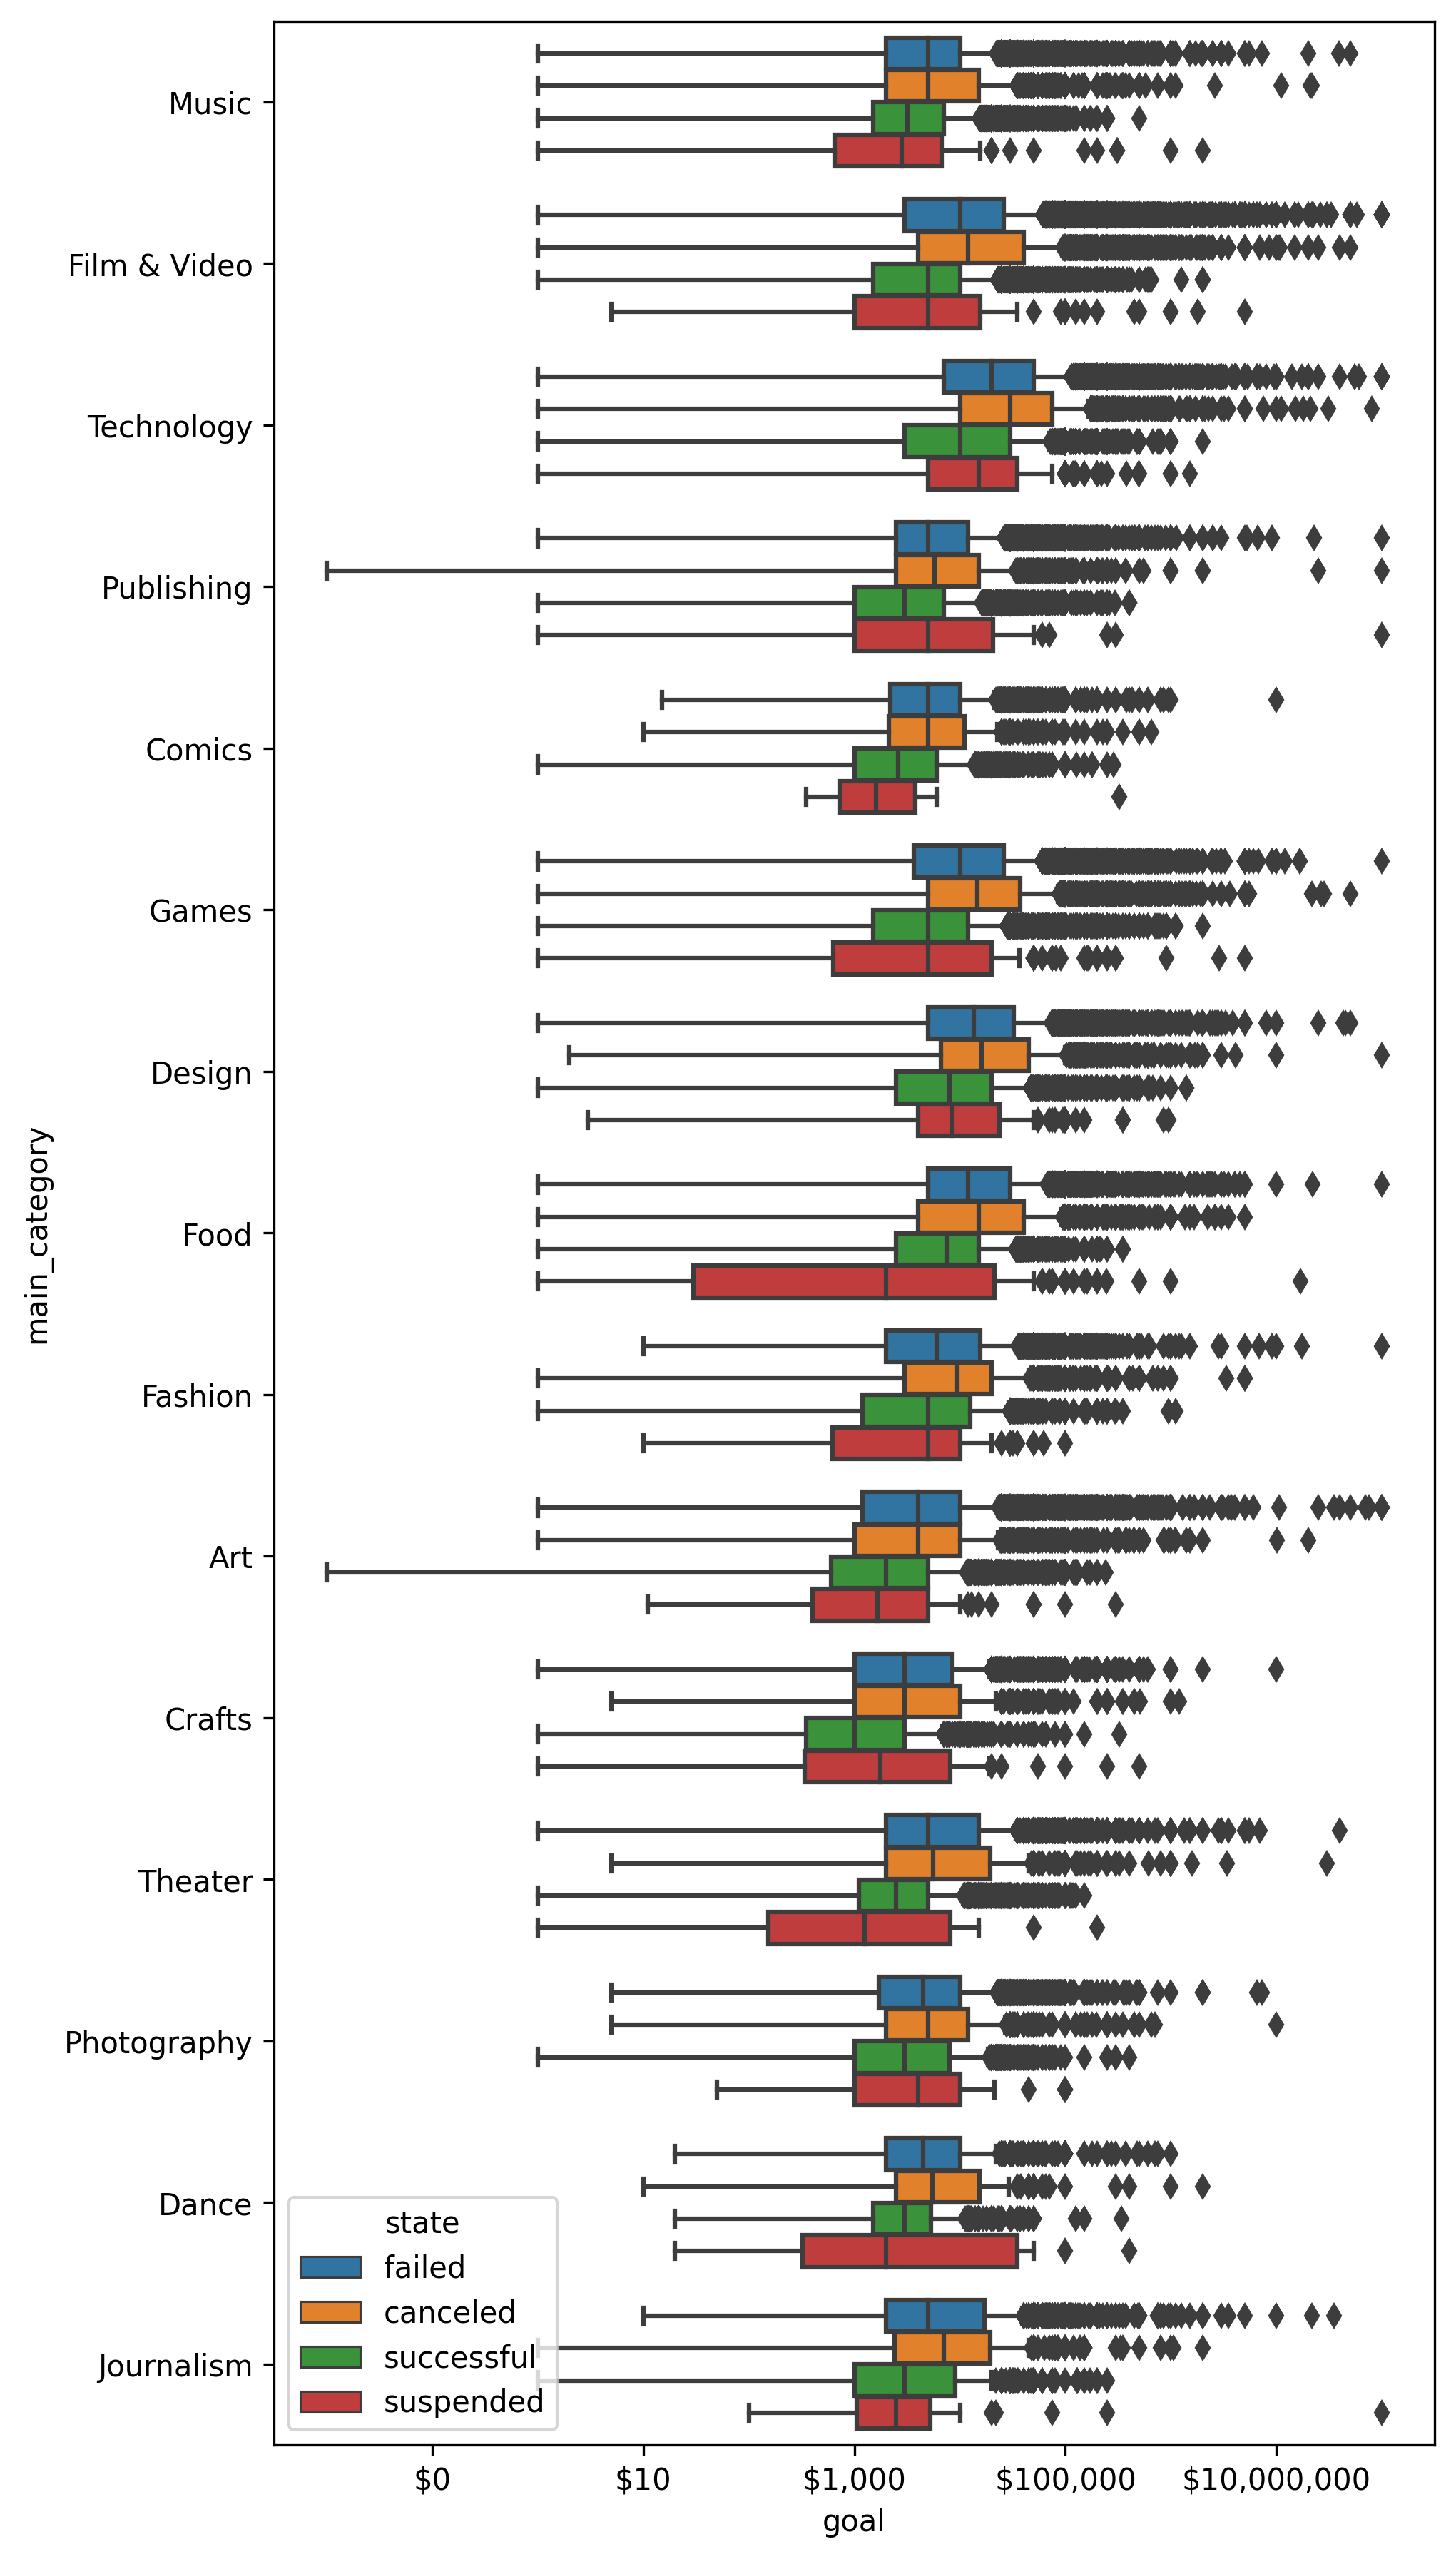

In [15]:
fg, ax = plt.subplots(dpi=300, figsize=(7, 15))
ax.set_xscale('log')

sns.boxplot(data=train, x='goal', y='main_category', hue='state')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

We can simplify it a bit and just look at the medians. It helps a little bit! 

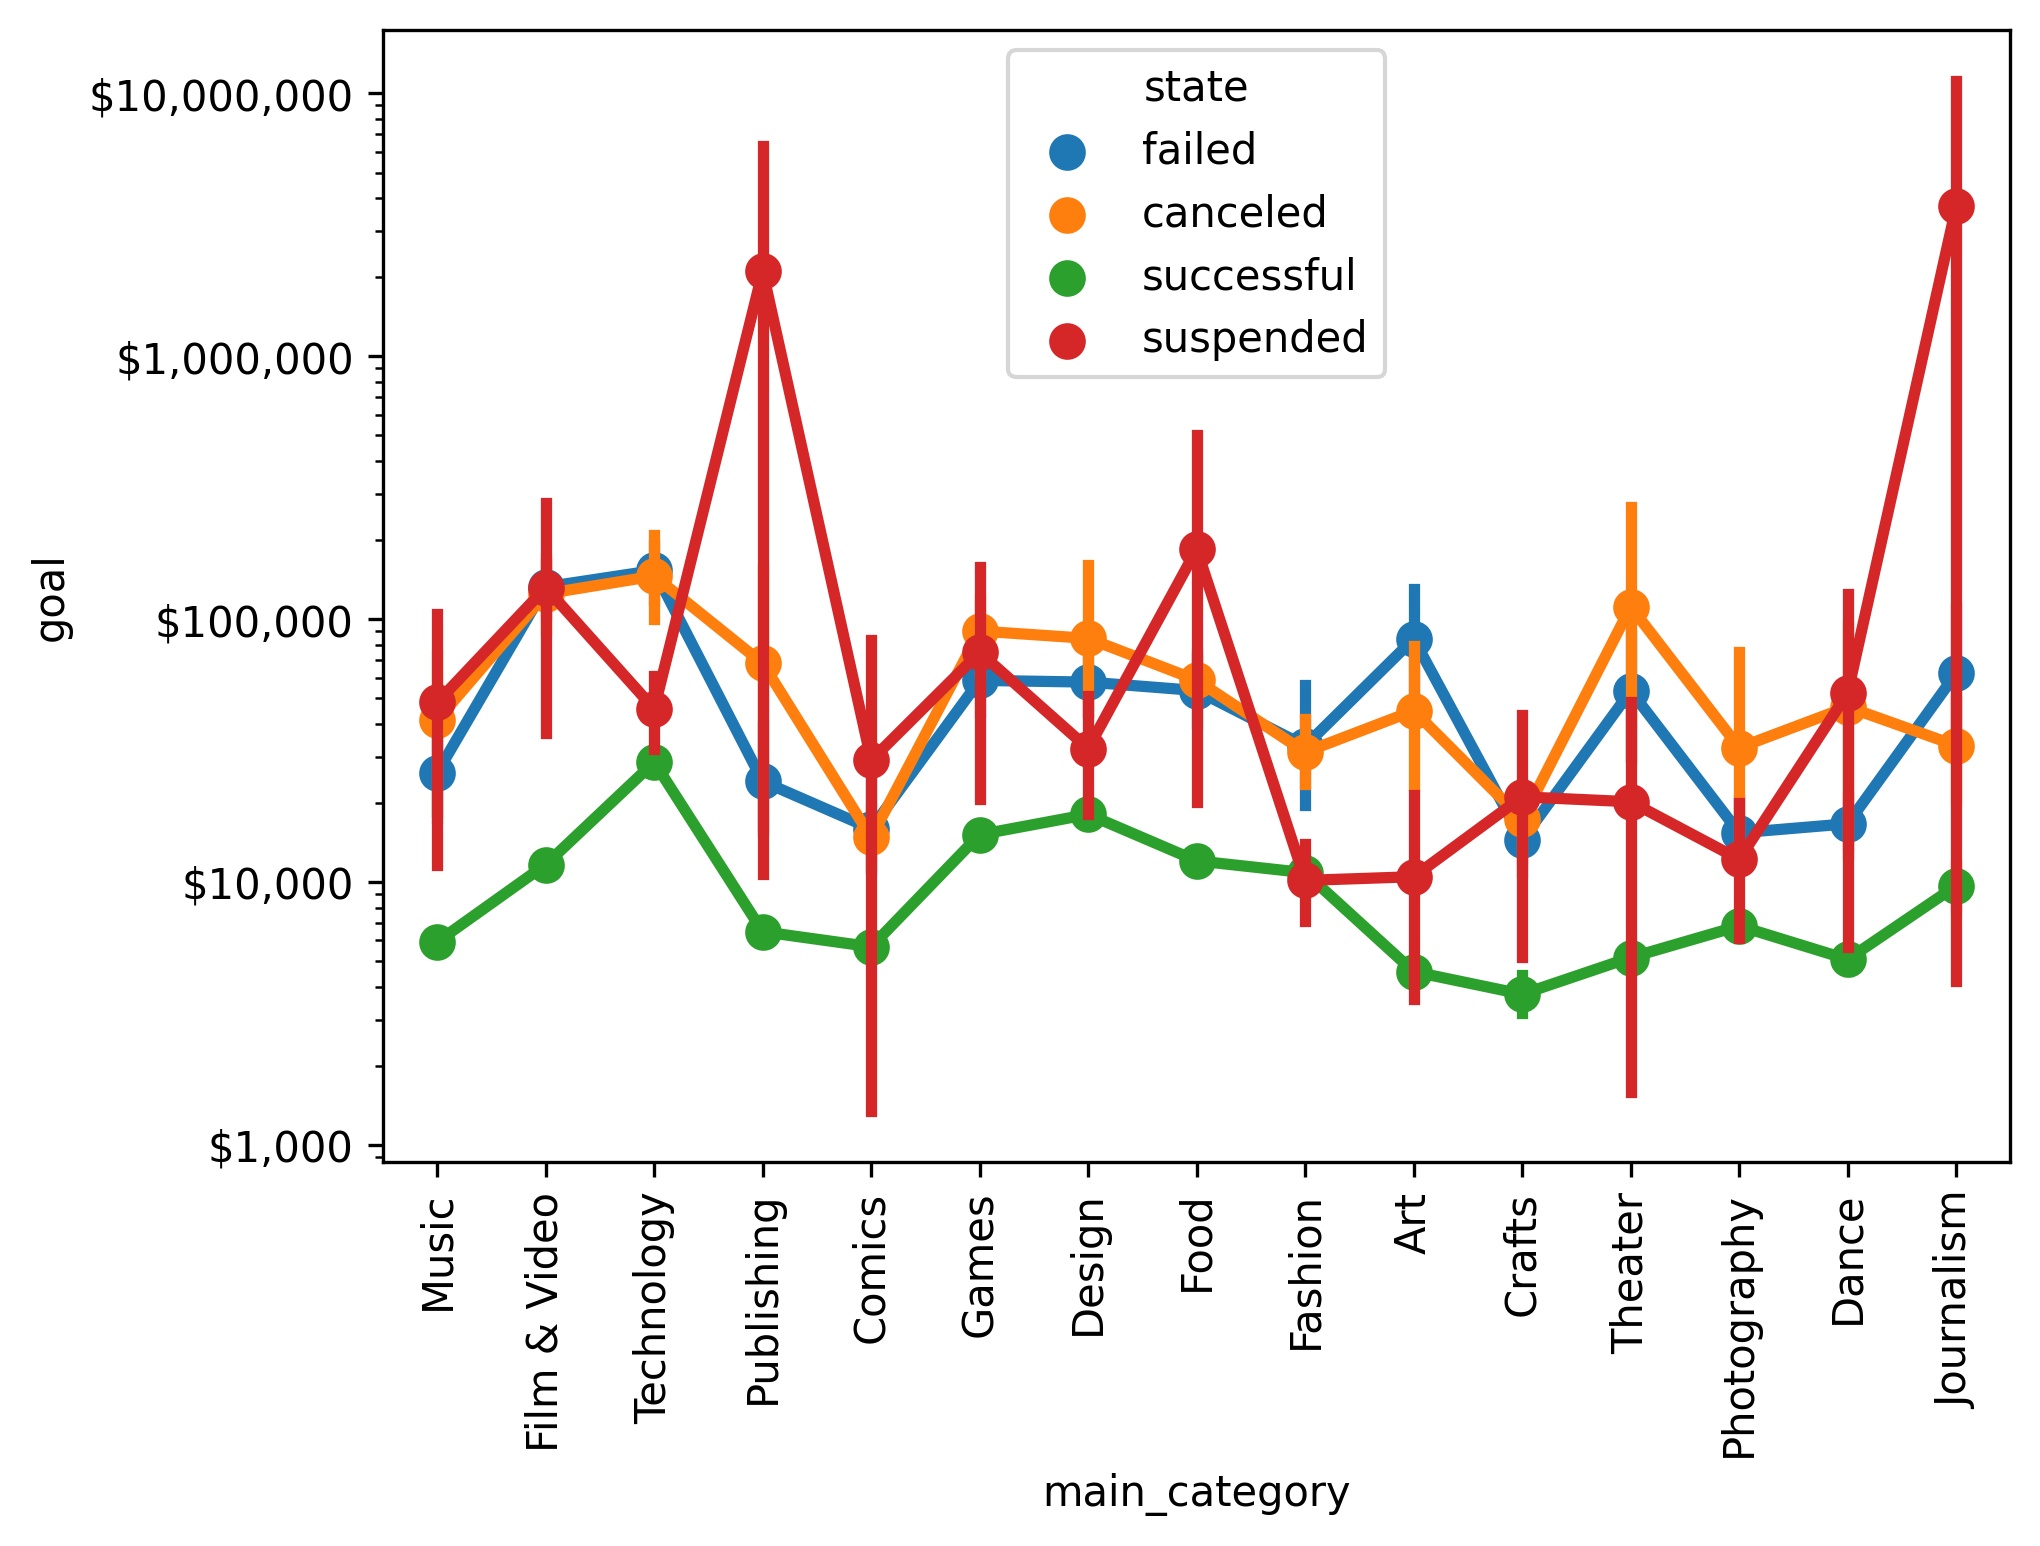

In [16]:
fg, ax = plt.subplots(dpi=300, figsize=(7, 5))
ax.set_yscale('log')

sns.pointplot(data=train, x='main_category', y='goal', hue='state', ax=ax)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# 3. Feature Engineering

Can we build any more useful columns?

## Numerical

## 3.1 Dates

We can compute the length of the project. Could be handy

In [17]:
train = train.copy()

In [18]:
train['project_duration_days'] = (train['deadline'] - train['launched']).dt.days
train['project_duration_days'] = train['project_duration_days'].clip(lower=0, upper=91)

In [19]:
train['project_duration_days'].describe()

count    260609.000000
mean         33.164837
std          12.792646
min           0.000000
25%          29.000000
50%          29.000000
75%          36.000000
max          91.000000
Name: project_duration_days, dtype: float64

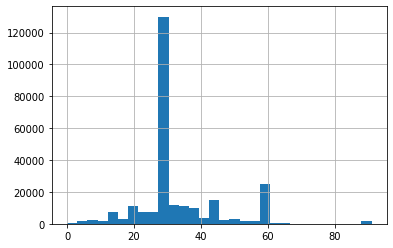

In [20]:
train['project_duration_days'].hist(bins=30)

We can also use the attributes of the datetime column to get the day of the week that the project launched!

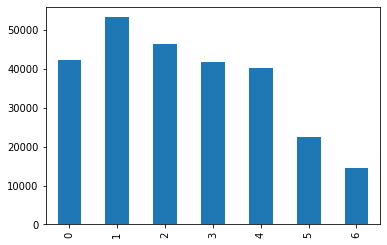

In [21]:
train['launched'].dt.dayofweek.value_counts().sort_index().plot(kind='bar')

In [22]:
train['launch_dayofweek'] = train['launched'].dt.dayofweek
train['launched_on_weekend'] = train['launch_dayofweek'] > 4

What about whether the project was launched at the weekend?

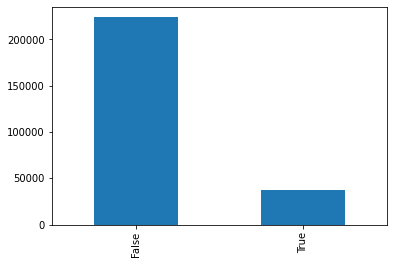

In [23]:
train['launched_on_weekend'].value_counts().plot(kind='bar')

### Testing our new features

Do we see any predictive power?

Cross tab looks at the interaction between our two. In this case, projects launched at the weekend have a slightly lower chance of being successful it seems!

In [24]:
pd.crosstab(train['launched_on_weekend'], train['state'], normalize='index', margins=True)

state,canceled,failed,successful,suspended
launched_on_weekend,,,,
False,0.103902,0.530024,0.361194,0.004880
True,0.104013,0.547773,0.342813,0.005400
All,0.103918,0.532533,0.358595,0.004954


In [25]:
pd.crosstab(train['launch_dayofweek'], train['state'], normalize='index', margins=True)

state,canceled,failed,successful,suspended
launch_dayofweek,,,,
0,0.105772,0.529308,0.359841,0.005079
1,0.105817,0.510785,0.378852,0.004547
2,0.102759,0.531438,0.360691,0.005112
3,0.104620,0.534937,0.355708,0.004735
4,0.099983,0.549494,0.345526,0.004998
5,0.105913,0.558749,0.330437,0.004901
6,0.101055,0.530677,0.362091,0.006177
All,0.103918,0.532533,0.358595,0.004954


## 3.2 Text

We can do lots of interesting stuff with the text too

In [26]:
train['name'] = train['name'].fillna('')
train['name_length'] = train['name'].str.len()

Looks like successful projects tend to have longer names than failed projects? Not sure how reliable this is.

In [27]:
train.groupby('state')['name_length'].mean()

state
canceled      40.150432
failed        32.819502
successful    36.283469
suspended     41.890782
Name: name_length, dtype: float64

We can also penalise those that use those pesky exclamation marks.

In [28]:
train['whacky_name'] = train['name'].str.contains('!')

Exclamation marks actually look way more likely to succeed! Create excitement and create megabucks

In [29]:
pd.crosstab(train['whacky_name'], train['state'], normalize='index', margins=True)

state,canceled,failed,successful,suspended
whacky_name,,,,
False,0.105021,0.539178,0.350891,0.004909
True,0.093099,0.467363,0.434146,0.005391
All,0.103918,0.532533,0.358595,0.004954


# 4. Exploratory Data Analysis (level 2) 

Ok we actually kinda did this above

# 5. Linear classifier

Logistic regression and a suite of related linear classifiers are available as `SGDClassifier` in scikit learn. It has a lot of parameters. So let's try to find the best fit for our problem.

In [30]:
y = train['state'] == 'successful'

In [31]:
# First lets create our training data
X = pd.concat([
    train[['whacky_name', 'launched_on_weekend']].astype(int),         # turn bools to ints
    train[['name_length', 'project_duration_days', 'usd_goal_real']],
    pd.get_dummies(train['main_category'], drop_first=True),   # dummy encode the categorical column
], axis=1)
X['usd_goal_real'] = np.log(X['usd_goal_real'])
X['usd_goal_real'] = (X['usd_goal_real'] - X['usd_goal_real'].mean()) / X['usd_goal_real'].std()
X['name_length'] = (X['name_length'])
X['name_length'] = (X['name_length'] - X['name_length'].mean()) / X['name_length'].std()

Now everything is a number! We always need to have a numerical only input vector.

In [32]:
X.head()

,whacky_name,launched_on_weekend,name_length,project_duration_days,usd_goal_real,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
41982,0,0,-1.119833,29,-0.280880,0,0,0,0,0,0,0,0,0,1,0,0,0,0
184726,0,0,0.133589,29,-0.005016,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7777,1,0,-0.054425,10,-1.366408,0,0,0,0,0,0,0,0,0,0,0,0,1,0
90573,1,0,0.133589,28,0.187451,0,0,0,0,0,0,0,0,0,0,0,1,0,0
114325,0,0,0.258931,13,-2.218926,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we fit a classifer. I'm choosing some sensible defaults. You can ignore these for now. But you might be wondering "why would we choose these?"

In [33]:
classifier = SGDClassifier(
    loss='log',
    penalty='l2',  # a type of regularisation to prevent overfitting
    alpha=0.01,   # regularisation strength
    fit_intercept=True,  # lets add an intercept term (the a in y=a+bx)
)

classifier.fit(X, y)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

How did we do compared to some dummy classifiers?

In [34]:
metrics.accuracy_score(y, classifier.predict(X))

0.6663200426692861

In [35]:
metrics.accuracy_score(y, np.zeros(len(y)))  # always predict zero

0.6414053236841398

**THIS IS NOT A FAIR TEST** because the crucial error. We are evaluating with the very same data that we used to fit the model. This is a recipe for disaster. Because it does not measure how well we would perform on **new data**, which we are almost always interested in.

### Use cross validation

When we use k-fold cross validation, we run `k` experiments. Each experiment trains on just a sample of the data. And predicts on the rest. We will end up with `k` different scores, one for each experiment. Each experiment is fair and we can get a good feel for model bias (the average score) and variance (the variation in the scores).

We're going to run 5 experiments!

In [36]:
cross_val_score(classifier, X, y, cv=5, scoring='accuracy')  # running 5 experiments!

array([0.65730402, 0.65855109, 0.66563064, 0.66022025, 0.66278467])

The outputs are very much the same showing low variance. But at the same time the scores are pretty poor (close to our dummy score of 64% earier on), so we have high bias. Maybe our model is not flexible enough!

In [37]:
classifier = SGDClassifier(
    loss='log',
    penalty='l2',  # a type of regularisation to prevent overfitting
    alpha=0.00001,   # Set the regularisation much lower
    fit_intercept=True,  # lets add an intercept term (the a in y=a+bx)
)

In [38]:
cross_val_score(classifier, X, y, cv=5, scoring='accuracy')  # running 5 experiments!

array([0.65225816, 0.66570738, 0.6507233 , 0.66254173, 0.66821435])

Now our results show more variation but some are better. Maybe there is a sensible middle ground!

# 6. Running a grid search

A **grid search** is what we call searching for the best hyperparameters. The idea is that we have a huge grid of possible combinations of hyperparameters. We want to test all of these and find the ones that produce a model with the best score!

Scikit-learn makes this really easy for us. Before then, everybody was writing their own code to do it, which is just a massive pain.

In [39]:
from sklearn.model_selection import GridSearchCV

Just for demo, we speed things up with a sample of the data. Just 20,000 rows.

In [40]:
select = np.random.randint(len(X), size=20_000)
X_sample = X.iloc[select].copy()
y_sample = y.iloc[select].copy()

Let's create a grid search:

 * `estimator` is the classifier or regressor that we want to tune. In this case it's `SGDClassifier`
 * `param_grid` is a dictionary of hyperparameters and a selection of values to test. The keys of the dictionary must be parameters for the estimator. For an `SGDClassifier` we have things like `alpha` `penalty` `log.
 * `scoring` is the metric we want to use to measure which parameter set is best. We look at accuracy.
 * `cv` the number of folds to use.
 
Note that parameters we fix are passed into the `SGDClassifier` and parameters we want to vary are put in the `param_grid`.

In [50]:
grid_search = GridSearchCV(
    estimator=SGDClassifier(loss='log', penalty='elasticnet', fit_intercept=True),  # the classifier or regressor we want to optimise
    param_grid={                                   # the grid is a dictionary, where keys are
        'alpha': np.logspace(-7, 1, 15),
    },
    scoring='accuracy',
    cv=3,
)

Now we call the `fit` method with our small sample of data.

This creates `15 * 3 = 45` experiments. Because we try `15` values of `alpha` and for each value we do a `3`-fold cross validated score.

In [51]:
grid_search.fit(X_sample, y_sample)

GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='elasticnet', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fractio...
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-07, 3.72759372e-07, 1.38949549e-06, 5.17947468e-06,
       1.93069773e-05, 7.19685673e-05, 2.68269580e-04, 1.00000000e-03,
       3.72759372e-03, 1.38949549e-02, 5.17947468e-02, 1.93069773e-01,
       7.19685673e-01, 2.6

We can get the winning score, the parameters that led to that score, and the model fitted with those parameters like so:

In [52]:
grid_search.best_score_

0.6638501108247917

In [53]:
grid_search.best_params_

{'alpha': 0.01389495494373136}

In [54]:
grid_search.best_estimator_

SGDClassifier(alpha=0.01389495494373136, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

The detailed results are available on the `cv_results_`, which is a dictionary. Below we print the keys

In [55]:
list(grid_search.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_alpha',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

### Visualising the grid search

Below we're plotting the scores for each value of the hyperparameter `alpha`. Remember that for each value of `alpha` we do 5-fold cross validation, so we actually get 5 different scores!

The plot shows the average score over all 5 experiments for each of the grid search values. **But that is not the whole story!**. When `alpha` is low (which makes the model more flexible and prone to overfitting), we can see that there is way more variance between individual experiments, which suggests that the model has much more **variance** even though some experiments showed low **bias** (i.e. a high score). How would you choose the best value?

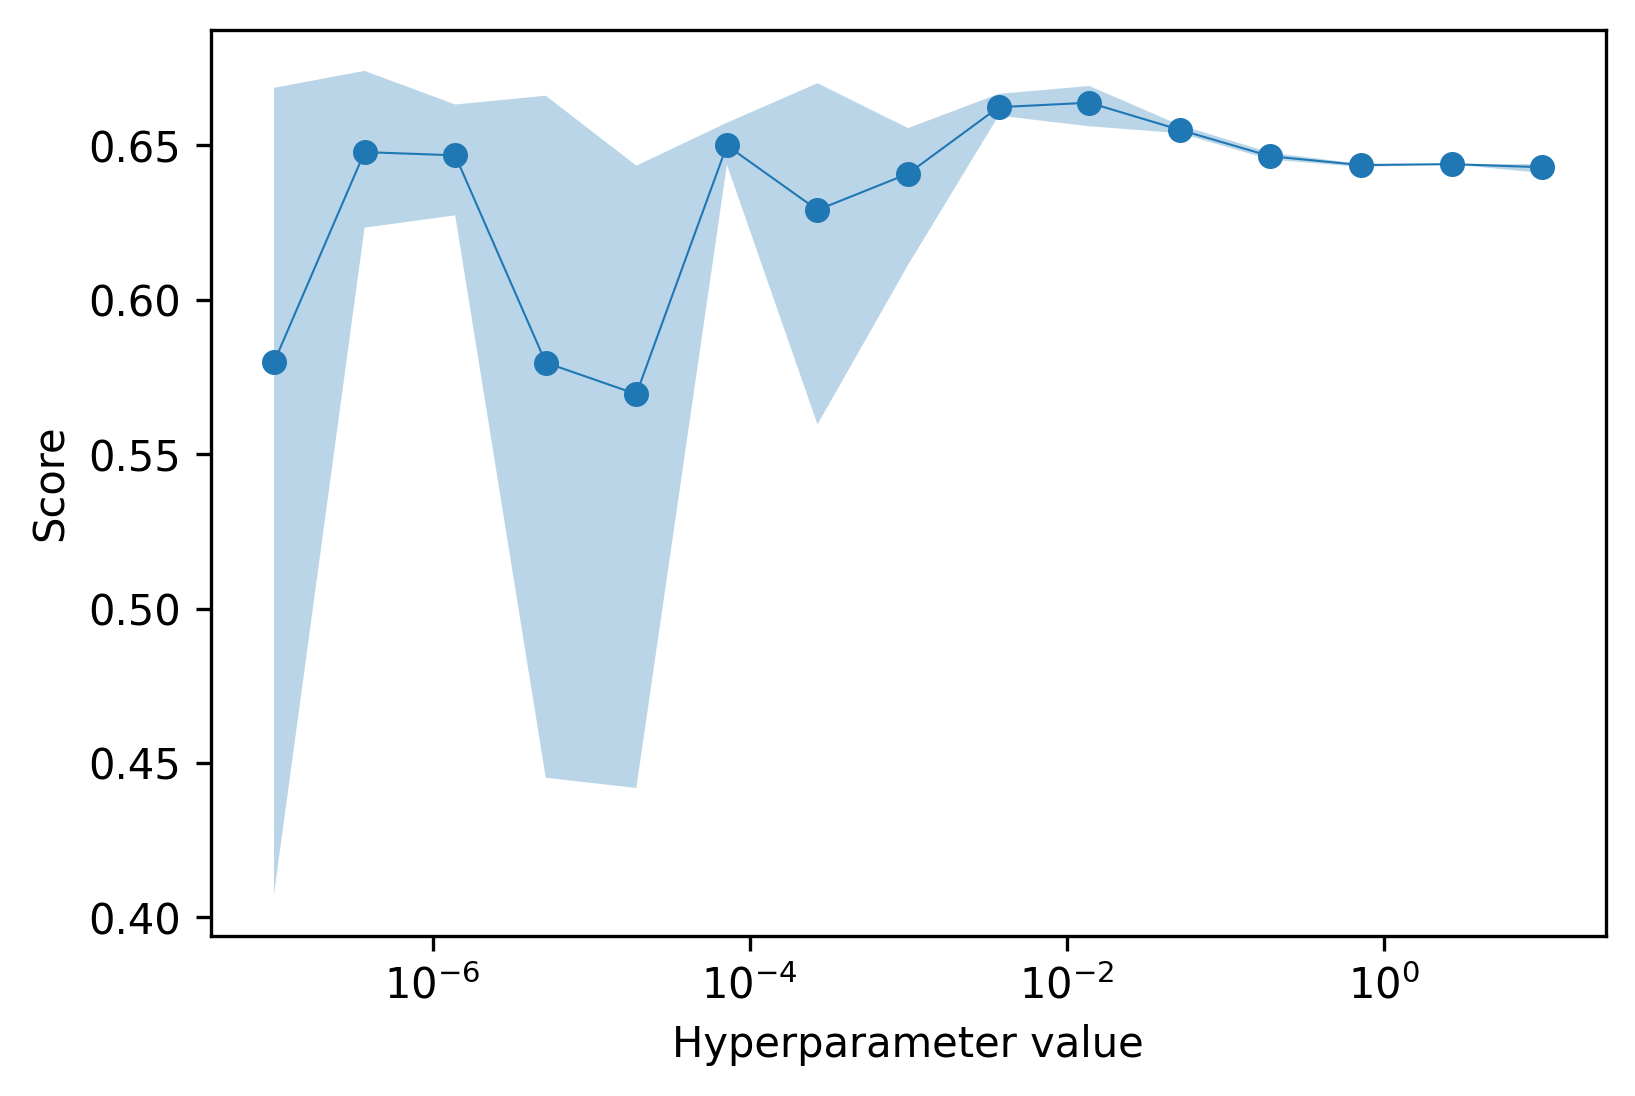

In [56]:
hyperparameters = [p['alpha'] for p in grid_search.cv_results_['params']]
average_scores = grid_search.cv_results_['mean_test_score']
all_scores = np.array([
    grid_search.cv_results_[f'split{i}_test_score']
    for i in range(grid_search.cv)
])
min_scores = all_scores.min(axis=0)
max_scores = all_scores.max(axis=0)

fg, ax = plt.subplots(dpi=300)
ax.set_xscale('log')

ax.fill_between(hyperparameters, min_scores, max_scores, alpha=0.3, label='Range of scores')
ax.plot(hyperparameters, average_scores, '.-', ms=10, lw=0.5, label='Average score')
ax.set_ylabel('Score')
ax.set_xlabel('Hyperparameter value');

$10^{-2}$ looks like a good balance with a high score on average and a bit of variance. If you were feeling more risk averse, you might take the point to the right with a very slightly lower average score but much less variance.

In [58]:
grid_search.best_params_

{'alpha': 0.01389495494373136}

# 6. Running the test set

So now let's run a fair test. 

We use all the training we've done to make predictions on our hold set.

We did a bunch of transformations to our training data that we now have to replicate for the test data. This is a bit of a pain and is exactly why writing a nice pipeline of transformations can help you.

In this case I'll be copy-pasting a bunch of stuff.

In [59]:
y_test = test['state'] == 'successful'

**VERY IMPORTANT** Note that I use the same scaling as the training set. So we use `X_train[...].mean()` and **NOT** `X[...].mean()` - otherwise we would be changing our features to match the test set better. If this doesn't make sense, think about it this way:

 - The model MUST NOT have any information from the future.
 - The mean of the test set is not available at training time, so we shouldn't use it at predict time

In [65]:
test = test.copy()

In [67]:
test['project_duration_days'] = (test['deadline'] - test['launched']).dt.days
test['project_duration_days'] = test['project_duration_days'].clip(lower=0, upper=91)

test['name'] = test['name'].fillna('')
test['name_length'] = test['name'].str.len()
test['whacky_name'] = test['name'].str.contains('!')
test['launch_dayofweek'] = test['launched'].dt.dayofweek
test['launched_on_weekend'] = test['launch_dayofweek'] > 4

For categoricals, we need to check that there are no new values. The function below show we have no surprises so let's keep going!

In [71]:
set(train['main_category'].unique()) - set(test['main_category'].unique())

set()

In [72]:
set(test['main_category'].unique()) - set(train['main_category'].unique())

set()

In [73]:
X_test = pd.concat([
    test[['whacky_name', 'launched_on_weekend']].astype(int),
    test[['name_length', 'project_duration_days', 'usd_goal_real']],
    pd.get_dummies(test['main_category'], drop_first=True),
], axis=1)
X_test['usd_goal_real'] = np.log(X_test['usd_goal_real'])
X_test['usd_goal_real'] = (X_test['usd_goal_real'] - X['usd_goal_real'].mean()) / X['usd_goal_real'].std()
X_test['name_length'] = (X_test['name_length'] - X['name_length'].mean()) / X['name_length'].std()

51% not too bad!

In [74]:
metrics.accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))

0.518184260005372

# 7. Pipeline

How annoying was it having to work on the feature preparation for training data, then having to repeat it for the testing data? 

**So annoying!!**

We can make that way easier by combining all our feature engineering into a pipeline

Check out this great reference for preprocessing options available in scikit-learn: https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

## 7.1 Build and train the pipeline

In [75]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

In [76]:
# This kind of feature engineering can't be automated into a pipeline
train['project_duration_days'] = (train['deadline'] - train['launched']).dt.days
train['project_duration_days'] = train['project_duration_days'].clip(lower=0, upper=91)

train['name'] = train['name'].fillna('')
train['name_length'] = train['name'].str.len()
train['whacky_name'] = train['name'].str.contains('!')
train['launch_dayofweek'] = train['launched'].dt.dayofweek
train['launched_on_weekend'] = train['launch_dayofweek'] > 4

### 7.1.1 One hot encoding for categoricals

The secret of pipelines is that it only `fits` during the training phase and then `transforms` when we make predictions. So for one hot encoding, we only encode categories available at training time.

In [78]:
onehot = preprocessing.OneHotEncoder?

In [81]:
onehot = preprocessing.OneHotEncoder(
    categories='auto',  # determine categories automatically
    drop=None,  # drop the first feature
    sparse=False,  # sparse data doesn't store zeroes (very useful for big data but we ignore here)
    dtype=np.int,  # use integers for the 1s and 0s
    handle_unknown='ignore',  # If a new category appears at predict time, just ignore it!
)

Study the following example carefully:

 * What happens to new values not available at train time?

In [85]:
# Training
cats = [['cat'], ['dog'], ['dog'], ['elephant']]
onehot.fit(cats);

In [87]:
# Transform
onehot.transform(cats)

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

What happens to mouse?!

In [88]:
# Transform new data
new_cats = [['cat'], ['cat'], ['mouse'], ['elephant'], ['dog']]
onehot.transform(new_cats)

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

### 7.1.2 Scaling numerical columns

There are loads of options for scaling our data. The aim here is to get everything looking reasonably normal: symmetrical around zero within the range of -5 to 5. This makes computation easier and makes all variables equally important. If you have values like 10,000,000 they would dominate the model.

In this example we use the `PowerTransformer` which tries to scale the data to look normal. See examples here: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py

This is a more automated alternative to our method of: 1) logging 2) removing mean 3) dividing by standard deviation

In [92]:
numerical_cols = ['name_length', 'project_duration_days', 'usd_goal_real']

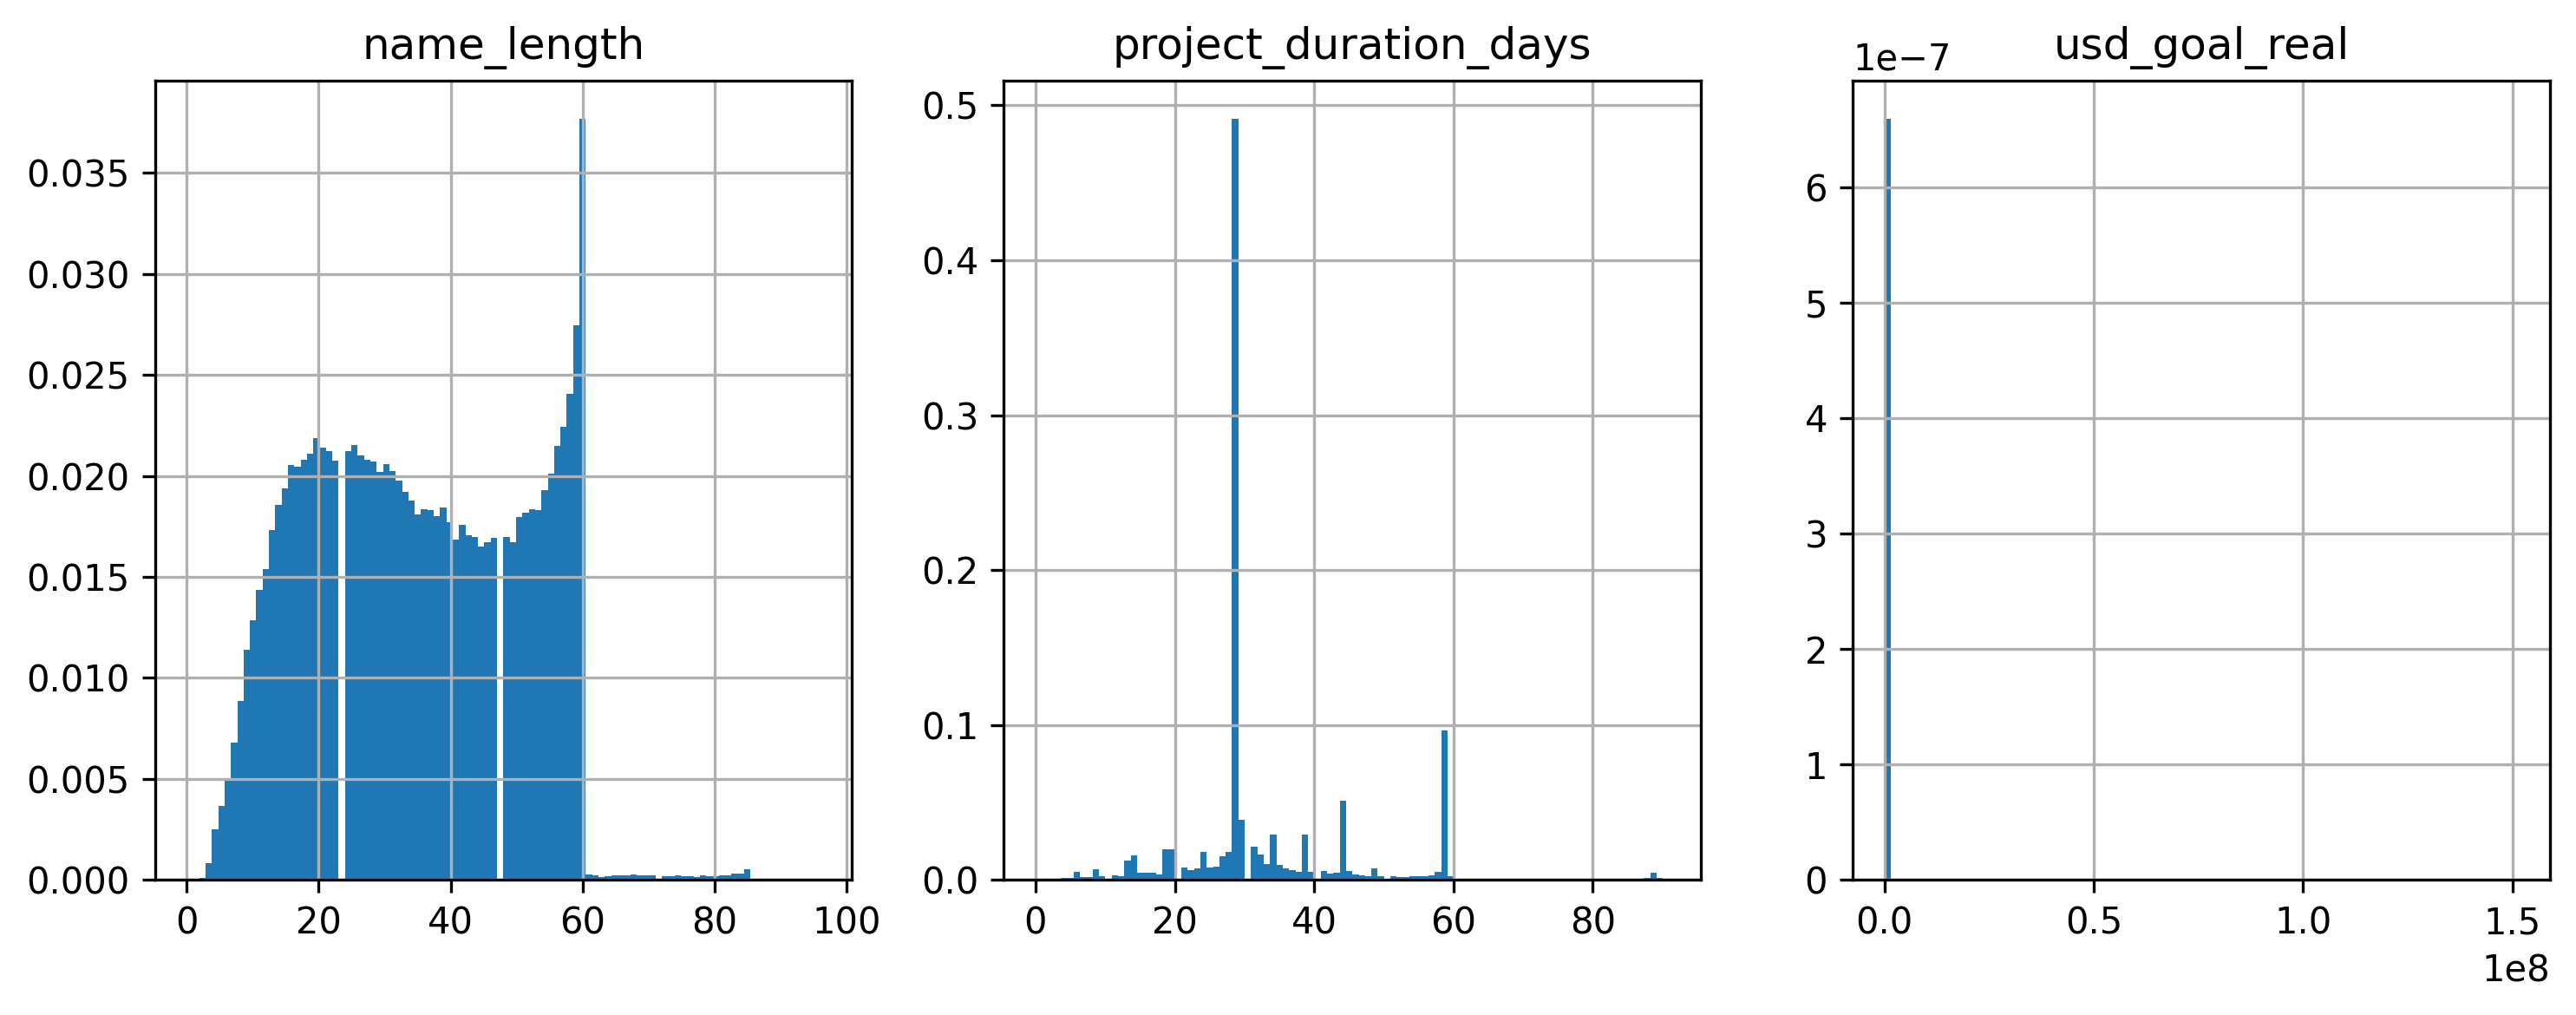

In [100]:
# Before
fg, axs = plt.subplots(dpi=300, ncols=3, figsize=(10, 4))
for col, ax in zip(numerical_cols, axs):
    train[col].hist(ax=ax, density=True, bins=100)
    ax.set_title(col)
fg.tight_layout()

In [101]:
# Training
transformer = preprocessing.PowerTransformer()
transformer.fit(train[numerical_cols]);

In [102]:
# Transform
scaled = transformer.transform(train[numerical_cols])

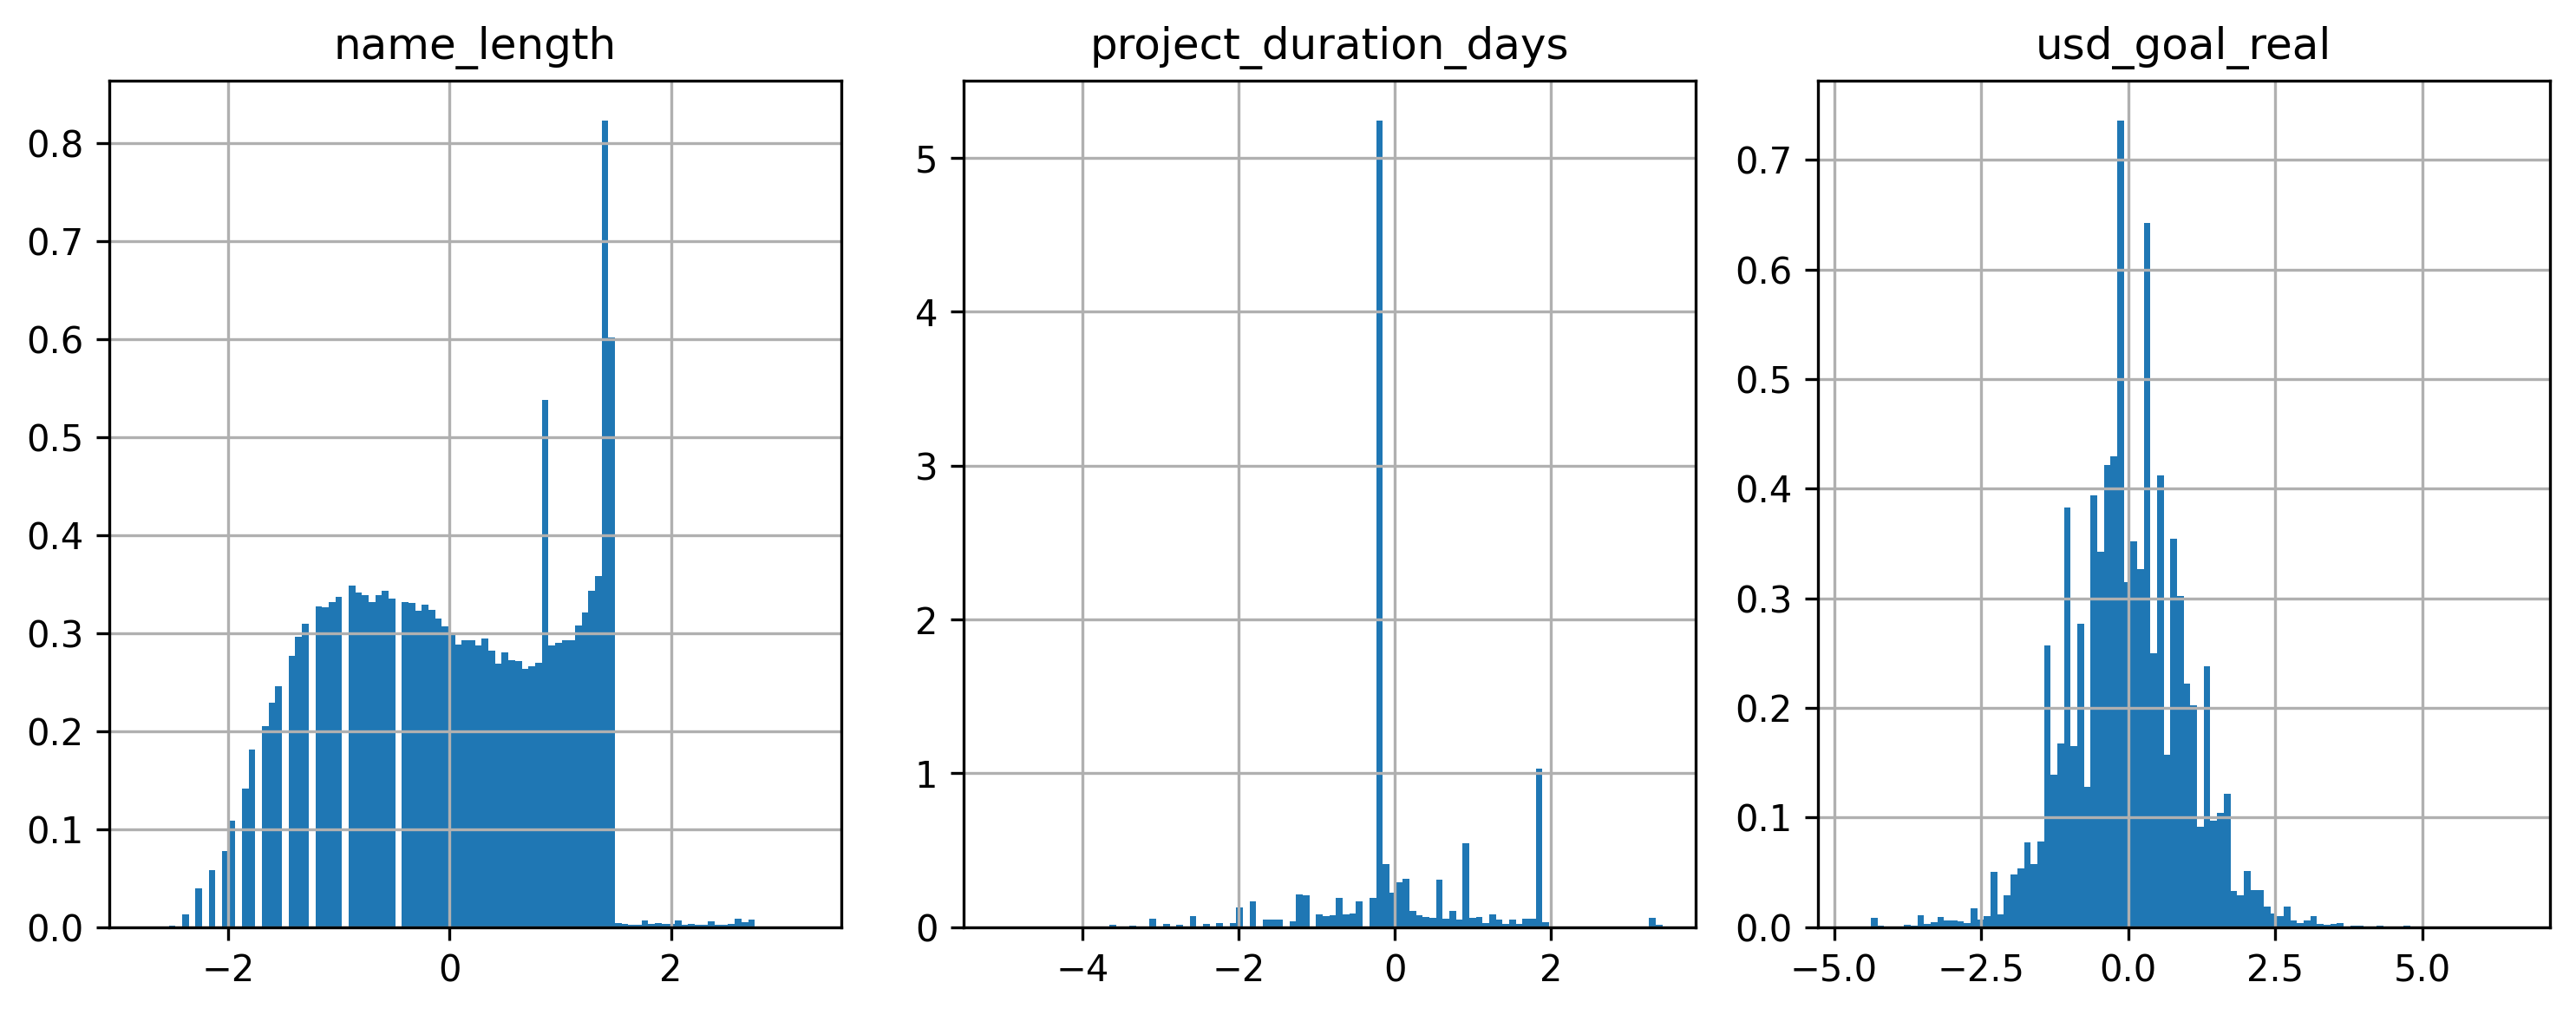

In [108]:
# After!
fg, axs = plt.subplots(dpi=300, ncols=3, figsize=(10, 4))
for col, vals, ax in zip(numerical_cols, scaled.T, axs):
    pd.Series(vals).hist(ax=ax, density=True, bins=100)
    ax.set_title(col)
fg.tight_layout()

### 7.1.3 Putting it all together for our feature engineering

We use the `ColumnTransformer` which lets us apply different transformers to different columns. It's so good.

In [109]:
from sklearn.compose import ColumnTransformer

In [111]:
features = ColumnTransformer(
    transformers=[
        ('onehot', preprocessing.OneHotEncoder(drop=None, handle_unknown='ignore'), ['main_category']),
        ('scaler', preprocessing.PowerTransformer(), ['name_length', 'project_duration_days', 'usd_goal_real'])
    ],
    remainder='passthrough'  # any other colunms just get used as-is
)

In [ ]:
X_test = pd.concat([
    test[['whacky_name', 'launched_on_weekend']].astype(int),
    test[['name_length', 'project_duration_days', 'usd_goal_real']],
    pd.get_dummies(test['main_category'], drop_first=True),
], axis=1)
X_test['usd_goal_real'] = np.log(X_test['usd_goal_real'])
X_test['usd_goal_real'] = (X_test['usd_goal_real'] - X['usd_goal_real'].mean()) / X['usd_goal_real'].std()
X_test['name_length'] = (X_test['name_length'] - X['name_length'].mean()) / X['name_length'].std()

In [115]:
# Training
feature_names = [
    'whacky_name', 'launched_on_weekend', 'name_length',
    'project_duration_days', 'usd_goal_real',
    'main_category'
]
features.fit(train[feature_names]);

Sick!

In [121]:
# Transform
result = features.transform(train[feature_names])
result[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.12509146, -0.23580385, -0.29782357,  0.        ,  0.        ])

### 7.1.4 Adding a classifier to our pipeline

We're almost there, we've got a whole pipeline to transform data but now we want to put all that transformed data in our classifier.

In [122]:
from sklearn.pipeline import Pipeline

In [123]:
transformer = ColumnTransformer(
    transformers=[
        ('onehot', preprocessing.OneHotEncoder(drop=None, handle_unknown='ignore'), ['main_category']),
        ('scaler', preprocessing.PowerTransformer(), ['name_length', 'project_duration_days', 'usd_goal_real'])
    ],
    remainder='passthrough'  # any other colunms just get used as-is
)

In [124]:
classifier = SGDClassifier()

In [125]:
pipeline = Pipeline(steps=[
    ('feature_processing', transformer),
    ('classifier', classifier),
])

So now all we have to do is pass in our raw data in one end of the pipe and we get a classifier out the other end!!

In [127]:
feature_names

['whacky_name',
 'launched_on_weekend',
 'name_length',
 'project_duration_days',
 'usd_goal_real',
 'main_category']

In [131]:
pipeline.fit(train[feature_names], y);

In [132]:
y_pred = pipeline.predict(train[feature_names])
y_pred[:5]

array([False, False, False, False,  True])

## 7.2 Running our pipeline for testing

Now we can pass raw data in there's no more processing to do for the test data!

Not bad

In [133]:
y_pred = pipeline.predict(test[feature_names])
metrics.accuracy_score(y_test, y_pred)

0.6485540334855403

## 7.3 Cross validation

A huge benefit of the pipeline is that now all our feature processing happens in each cross validation too. So we get an even more fair test of performance!

**we only need 1 line to do 5-fold cross validated scoring on our training data

In [137]:
cross_val_score(pipeline, train[feature_names], y)

array([0.65339012, 0.6509919 , 0.65281455, 0.6511262 , 0.65273114])

## 7.4 Grid search gets crazy!

Remember that we did a grid search over the hyperparameters of our predictor. Now we can search over different transformations too.

To pass parameters to different stages of the pipeline we use double underscore `__` to separate the name from the parameter.

In [141]:
preprocessing.PowerTransformer?

In [142]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={
        'classifier__alpha': np.logspace(-7, 1, 6),
        'classifier__loss': ['hinge', 'log'], 
        'feature_processing__scaler__standardize': [True, False]  # try scaling with out without standardisation
    },
    scoring='accuracy',
    cv=3,
)

**WARNING** takes some time! Like 15 mins? Maybe longer.

In [143]:
grid_search.fit(train[feature_names], y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='ignore',
                      

## 7.5 Best parameters

So we've got our best classifier parameters and we can see that standardisation is best.

In [144]:
grid_search.best_params_

{'classifier__alpha': 0.00015848931924611142,
 'classifier__loss': 'log',
 'feature_processing__scaler__standardize': True}

## 7.6 Testing the ultimate pipeline

In [146]:
y_pred = grid_search.best_estimator_.predict(test[feature_names])

In [147]:
metrics.accuracy_score(y_test, y_pred)

0.6692720923986033

Not bad.